In [1]:
import os
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [3]:
J = 7
L = 4

conv_dir = '/n/netscratch/dvorkin_lab/Lab/gvalogiannis/maps_cmbl_georgios_2/'

cmb_survey = 'Planck'
wl_survey = 'dr3'
comb_survey = cmb_survey + '_x_' + wl_survey
write_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_x_wl/'+comb_survey+'_wph_j'+str(J)+'_l'+str(L)+'/'

In [5]:
def file_num(s, directory=True):
    # Find the index of the last '_', this is right before the number
    start = s.rfind('_')
    if directory:
        return s[start + 1:]
    else:
        end = s.rfind('.')
        return s[start + 1:end]

In [8]:
planck_mask = np.load('/n/netscratch/dvorkin_lab/Lab/kboone/cmb_conv/masks/Planck.npy')

In [6]:
all_dirs = np.array(os.listdir(conv_dir))
    
fid_inds = [i for i, s in enumerate(all_dirs) if s.startswith('f')]
Om_inds = [i for i, s in enumerate(all_dirs) if s.startswith('Om_p')]
s8_inds = [i for i, s in enumerate(all_dirs) if s.startswith('s8_p')]

fid_dirs = all_dirs[fid_inds]
Om_dirs = all_dirs[Om_inds]
s8_dirs = all_dirs[s8_inds]

fid_nums = []
Om_nums = []
s8_nums = []
for fid_dir in fid_dirs:
    fid_nums.append(file_num(fid_dir))
for Om_dir in Om_dirs:
    Om_nums.append(file_num(Om_dir))
for s8_dir in s8_dirs:
    s8_nums.append(file_num(s8_dir))
fid_nums = np.array(fid_nums)
Om_nums = np.array(Om_nums)
s8_nums = np.array(s8_nums)  

written_files = np.array(os.listdir(write_dir))

fid_inds_written = [i for i, s in enumerate(written_files) if s.startswith('f')]
Om_inds_written = [i for i, s in enumerate(written_files) if s.startswith('O')]
s8_inds_written = [i for i, s in enumerate(written_files) if s.startswith('s')]

fid_files = written_files[fid_inds_written]
Om_files = written_files[Om_inds_written]
s8_files = written_files[s8_inds_written]

fid_nums_written = []
Om_nums_written = []
s8_nums_written = []
for fid_file in fid_files:
    fid_nums_written.append(file_num(fid_file, directory=False))
    fid_nums_written.append('773')
for Om_file in Om_files:
    Om_nums_written.append(file_num(Om_file, directory=False))
for s8_file in s8_files:
    s8_nums_written.append(file_num(s8_file, directory=False))
fid_nums_written = np.array(fid_nums_written)
Om_nums_written = np.array(Om_nums_written)
s8_nums_written = np.array(s8_nums_written)

process_dirs = np.append(np.append(fid_dirs[~np.isin(fid_nums, fid_nums_written)], Om_dirs[~np.isin(Om_nums, Om_nums_written)]), s8_dirs[~np.isin(s8_nums, s8_nums_written)])

In [7]:
process_dirs

array(['fiducial_0', 'fiducial_1', 'fiducial_10', ..., 's8_p_97',
       's8_p_98', 's8_p_99'], dtype='<U12')

In [43]:
cmb_mask_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_conv/masks/'
wl_mask_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_x_wl/wl_masks/'

cmb_mask_files = os.listdir(cmb_mask_dir)
cmb_surveys = [cmb_mask_file.rstrip("npy") for cmb_mask_file in cmb_mask_files]
cmb_surveys = [cmb_survey.rstrip(".") for cmb_survey in cmb_surveys]
# Don't want SPT_main or SPT_summer
cmb_surveys = cmb_surveys[:-2]

cmb_mask_maps = []
for cmb_survey in cmb_surveys:
    cmb_mask_maps.append(np.load(cmb_mask_dir + cmb_survey + '.npy'))
    
wl_mask_files = os.listdir(wl_mask_dir)
wl_surveys = [wl_mask_file.rstrip("npy") for wl_mask_file in wl_mask_files]
wl_surveys = [wl_survey.rstrip(".") for wl_survey in wl_surveys]

wl_mask_maps = []
for wl_survey in wl_surveys:
    wl_mask_maps.append(np.load(wl_mask_dir + wl_survey + '.npy'))

In [44]:
wl_surveys

['dr1', 'dr3']

# ACT Noise and View Masks

In [35]:
def flip_map(m):
    nside = hp.get_nside(m)
    idx   = np.arange(m.size)
    x, y, z = hp.pix2vec(nside, idx)   # unit vectors
    idx2 = hp.vec2pix(nside, x, y, -z)
    return m[idx2]

In [36]:
nside = 1024
nside_ls = 3*nside

In [41]:
cmb_mask_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_conv/masks/'
cmb_mask_map = np.load(cmb_mask_dir + 'ACT.npy')
wl_mask_map = np.load('/n/netscratch/dvorkin_lab/Lab/kboone/cmb_x_wl/wl_masks/dr3.npy')
both_map = cmb_mask_map + wl_mask_map - 1
both_map[np.where(both_map < 0.5)] = 0

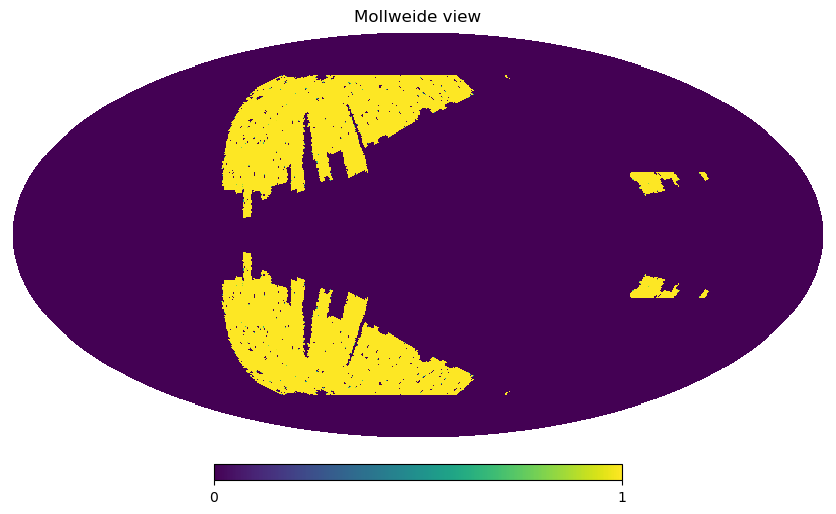

In [42]:
hp.mollview(both_map + antipode_map(both_map))

In [77]:
def get_noise():
    noise_ACT = np.loadtxt('/n/home09/kboone/software/Data/Map_Noise/ACT_noise.txt')[:,1]
    noise_ACT = noise_ACT[:np.where(noise_ACT < 1e-9)[0][0]]
    # Has an lmax of 2090
    # noise = np.ones(nside_ls)
    # noise[:len(noise_ACT)] = noise_ACT
    nn = hp.synfast(noise_ACT,nside=nside)
    return nn

In [78]:
conv_dir = '/n/netscratch/dvorkin_lab/Lab/gvalogiannis/maps_cmbl_georgios_2/'
all_dirs = np.array(os.listdir(conv_dir))
fid_inds = [i for i, s in enumerate(all_dirs) if s.startswith('f')]
fid_dirs = all_dirs[fid_inds]

In [79]:
cmb_map_noiseless = np.load(conv_dir + fid_dirs[0] + '/cmbl_1024.npy', allow_pickle=True).item()['map']

In [80]:
cmb_noise = get_noise()

In [81]:
cmb_map = cmb_map_noiseless + cmb_noise

In [97]:
alm = hp.map2alm(cmb_map, lmax=2090)

In [98]:
test = hp.alm2map(alm, nside)

In [99]:
cl = hp.anafast(test)
signal = hp.anafast(cmb_map_noiseless)
noise = hp.anafast(cmb_noise)

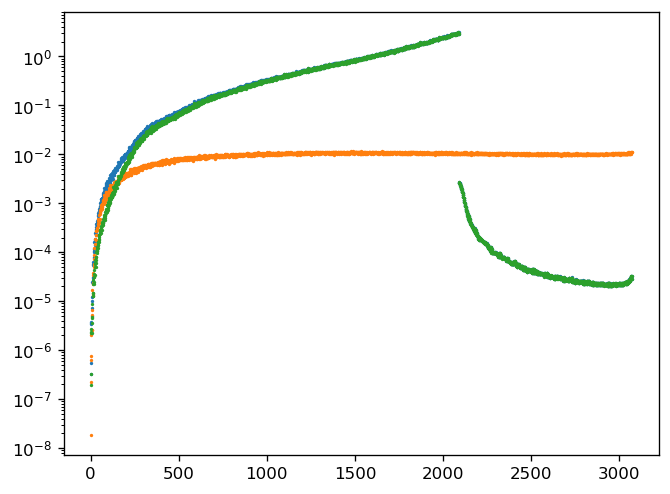

In [100]:
ls = np.arange(len(cl))
plt.figure(dpi = 120)
plt.scatter(ls, cl*ls*(ls+1),s=1)
plt.scatter(ls, signal*ls*(ls+1),s=1)
plt.scatter(ls, noise*ls*(ls+1),s=1)
plt.yscale('log')
plt.show()

# Cross $C_\ell$

In [6]:
conv_dir = '/n/netscratch/dvorkin_lab/Lab/gvalogiannis/maps_cmbl_georgios_2/'

In [8]:
def file_num(s, directory=True):
    # Find the index of the last '_', this is right before the number
    start = s.rfind('_')
    if directory:
        return s[start + 1:]
    else:
        end = s.rfind('.')
        return s[start + 1:end]

In [9]:
all_dirs = np.array(os.listdir(conv_dir))
    
fid_inds = [i for i, s in enumerate(all_dirs) if s.startswith('f')]
Om_inds = [i for i, s in enumerate(all_dirs) if s.startswith('Om_p')]
s8_inds = [i for i, s in enumerate(all_dirs) if s.startswith('s8_p')]

fid_dirs = all_dirs[fid_inds]
Om_dirs = all_dirs[Om_inds]
s8_dirs = all_dirs[s8_inds]

# Add in the flipped "directories"
Om_f_dirs = []
s8_f_dirs = []
for Om_dir in Om_dirs:
    Om_num = file_num(Om_dir)
    Om_f_dirs.append(Om_dir.replace(Om_num, Om_num+'f'))

In [4]:
nside = 1024
nside_ls = 3*nside

In [101]:
write_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_x_wl/raw_cross_cls/'
all_dirs = np.array(os.listdir(write_dir))
Om_inds = [i for i, s in enumerate(all_dirs) if s.startswith('O')]
Om_files = all_dirs[Om_inds]
survey = 'SPT_x_dr3'
data_len = 2*nside_ls

In [102]:
np.load(write_dir + Om_files[0], allow_pickle=True).item()

{'ACT_x_dr1_low_z': array([6.04905110e-06, 6.93529103e-06, 7.91581540e-06, ...,
        3.11850312e-06, 1.72395700e-06, 1.54953363e-07]),
 'ACT_x_dr1_high_z': array([-2.26863253e-06,  4.30953243e-07,  4.46740313e-06, ...,
         6.18152017e-06,  4.94320669e-06,  3.67811551e-06]),
 'ACT_x_dr3_low_z': array([ 3.30465031e-06, -5.70060305e-07,  3.61780883e-06, ...,
        -1.91075089e-06, -4.13329168e-07,  8.12175980e-07]),
 'ACT_x_dr3_high_z': array([ 2.30382843e-05,  1.68327509e-05,  2.05626430e-05, ...,
        -2.32073653e-06, -1.25585564e-06,  9.24353980e-07]),
 'Planck_x_dr1_low_z': array([-2.77367164e-08,  1.42170001e-07, -4.77440588e-08, ...,
        -4.53687852e-10,  4.85637777e-11, -2.30377683e-10]),
 'Planck_x_dr1_high_z': array([-7.02969243e-08,  2.09352390e-07, -6.63185175e-08, ...,
        -3.16346451e-10,  1.07311325e-10, -1.43653711e-10]),
 'Planck_x_dr3_low_z': array([ 7.57724686e-08,  7.29448980e-07, -4.78911104e-08, ...,
         2.27071497e-12,  1.08697929e-10,  1.83

In [18]:
not_flipped = ['f' not in Om_file for Om_file in Om_files]
flipped = ['f' in Om_file for Om_file in Om_files]

In [19]:
derivs = np.zeros((np.sum(not_flipped), data_len), dtype = np.float64)
for i in np.arange(len(Om_files[not_flipped])):
    derivs[i] = np.append(np.load(write_dir + Om_files[not_flipped][i], allow_pickle=True).item()[survey+'_low_z'][:int(data_len/2)], 
                     np.load(write_dir + Om_files[not_flipped][i], allow_pickle=True).item()[survey+'_high_z'][:int(data_len/2)])
derivs = np.average(derivs, axis=0)

In [20]:
derivs_f = np.zeros((np.sum(flipped), data_len), dtype = np.float64)
for i in np.arange(len(Om_files[flipped])):
    derivs_f[i] = np.append(np.load(write_dir + Om_files[flipped][i], allow_pickle=True).item()[survey+'_low_z'][:int(data_len/2)], 
                     np.load(write_dir + Om_files[flipped][i], allow_pickle=True).item()[survey+'_high_z'][:int(data_len/2)])
derivs_f = np.average(derivs_f, axis=0)

In [21]:
ls = np.arange(nside_ls)
ls = np.append(ls, ls)

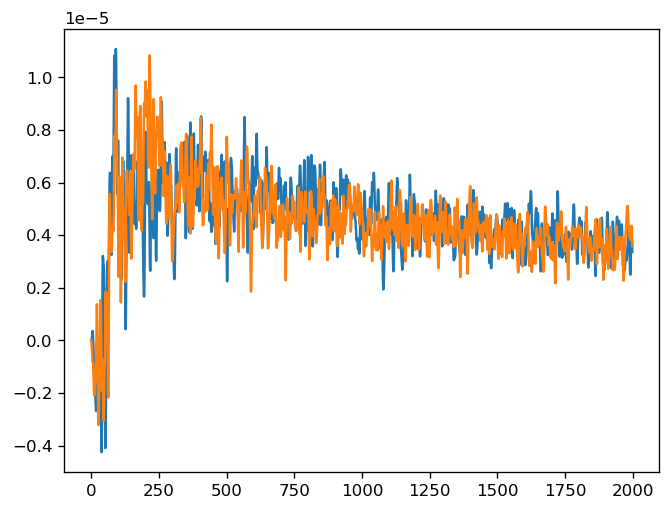

In [22]:
plt.figure(dpi = 120)
plt.plot((ls*derivs)[3072:5072])
plt.plot((ls*derivs_f)[3072:5072])
plt.show()

# WPH

In [26]:
cmb_survey = 'SPT'
wl_survey = 'dr3'
survey = cmb_survey + '_' + wl_survey

In [29]:
conv_dir = '/n/netscratch/dvorkin_lab/Lab/gvalogiannis/maps_cmbl_georgios_2/'
cmb_mask_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_conv/masks/'
wl_mask_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_x_wl/wl_masks/'
patch_dir = '/n/home09/kboone/software/Data/Patches/'

cmb_mask_map = np.load(cmb_mask_dir + cmb_survey + '.npy')
wl_mask_map = np.load(wl_mask_dir + wl_survey + '.npy')

total_mask = cmb_mask_map + wl_mask_map + 1
    
patch_inds_all = np.load(patch_dir + 'patches_nside_1024.npy')
unmask_all = patch_inds_all > -0.5

patches_get_weights = np.zeros_like(patch_inds_all)
patches_get_weights[unmask_all] = np.take(total_mask, patch_inds_all[unmask_all])

weights = []
for i in np.arange(len(patches_get_weights)):
    weights.append(len(np.where(patches_get_weights[i] > 2.5)[0]) / len(np.where(patches_get_weights[i] > 0.5)[0]))
weights = np.array(weights)
weights[np.where(weights<0.2)[0]] = 0

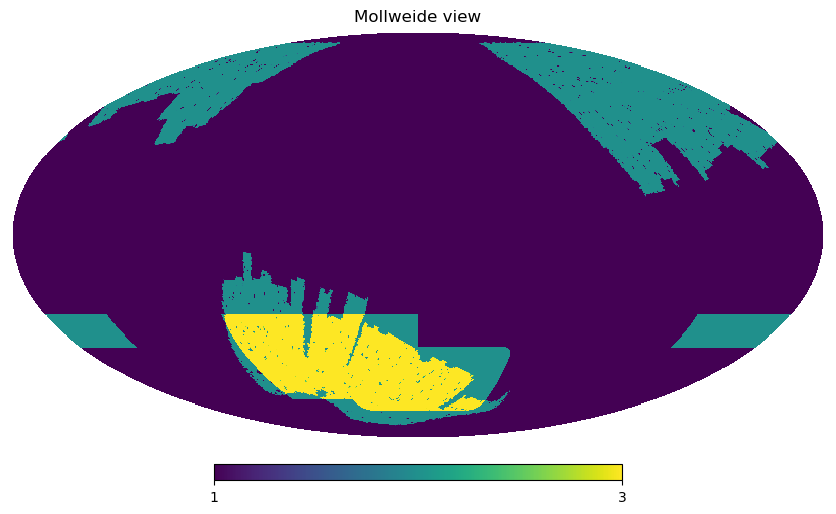

In [30]:
hp.mollview(total_mask)

In [3]:
def file_num(s, directory=True):
    # Find the index of the last '_', this is right before the number
    start = s.rfind('_')
    if directory:
        return s[start + 1:]
    else:
        end = s.rfind('.')
        return s[start + 1:end]

In [4]:
conv_dir = '/n/netscratch/dvorkin_lab/Lab/gvalogiannis/maps_cmbl_georgios_2/'
write_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_x_wl/raw_cross_cls/'

In [5]:
cmb_mask_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_conv/masks/'
wl_mask_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_x_wl/wl_masks/'

In [6]:
# mask_files = os.listdir(cmb_mask_dir)
# surveys = [mask_file.rstrip("npy") for mask_file in mask_files]
# surveys = [survey.rstrip(".") for survey in surveys]
# # Don't want SPT_main or SPT_summer
# surveys = surveys[:4]
# surveys

In [7]:
# mask_files = os.listdir(wl_mask_dir)
# surveys = [mask_file.rstrip("npy") for mask_file in mask_files]
# surveys = [survey.rstrip(".") for survey in surveys]
# surveys

In [8]:
conv_dir = '/n/netscratch/dvorkin_lab/Lab/gvalogiannis/maps_cmbl_georgios_2/'

cmb_mask_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_conv/masks/'
wl_mask_dir = '/n/netscratch/dvorkin_lab/Lab/kboone/cmb_x_wl/wl_masks/'

cmb_mask_files = os.listdir(cmb_mask_dir)
cmb_surveys = [cmb_mask_file.rstrip("npy") for cmb_mask_file in cmb_mask_files]
cmb_surveys = [cmb_survey.rstrip(".") for cmb_survey in cmb_surveys]
# Don't want SPT_main or SPT_summer
cmb_surveys = cmb_surveys[0:4]

# cmb_mask_maps = []
# for cmb_survey in cmb_surveys:
#     cmb_mask_maps.append(np.load(cmb_mask_dir + cmb_survey + '.npy'))
    
wl_mask_files = os.listdir(wl_mask_dir)
wl_surveys = [wl_mask_file.rstrip("npy") for wl_mask_file in wl_mask_files]
wl_surveys = [wl_survey.rstrip(".") for wl_survey in wl_surveys]

# wl_mask_maps = []
# for wl_survey in wl_surveys:
#     wl_mask_maps.append(np.load(wl_mask_dir + wl_survey + '.npy'))

In [9]:
# len(np.loadtxt('../Data/Map_Noise/ACT_noise.txt')[:,1])

In [10]:
all_dirs = np.array(os.listdir(conv_dir))
    
fid_inds = [i for i, s in enumerate(all_dirs) if s.startswith('f')]
Om_inds = [i for i, s in enumerate(all_dirs) if s.startswith('Om_p')]
s8_inds = [i for i, s in enumerate(all_dirs) if s.startswith('s8_p')]

fid_dirs = all_dirs[fid_inds]
Om_dirs = all_dirs[Om_inds]
s8_dirs = all_dirs[s8_inds]

fid_nums = []
Om_nums = []
s8_nums = []
for fid_dir in fid_dirs:
    fid_nums.append(file_num(fid_dir))
for Om_dir in Om_dirs:
    Om_nums.append(file_num(Om_dir))
for s8_dir in s8_dirs:
    s8_nums.append(file_num(s8_dir))
fid_nums = np.array(fid_nums)
Om_nums = np.array(Om_nums)
s8_nums = np.array(s8_nums)  

written_files = np.array(os.listdir(write_dir))

fid_inds_written = [i for i, s in enumerate(written_files) if s.startswith('f')]
Om_inds_written = [i for i, s in enumerate(written_files) if s.startswith('O')]
s8_inds_written = [i for i, s in enumerate(written_files) if s.startswith('s')]

fid_files = written_files[fid_inds_written]
Om_files = written_files[Om_inds_written]
s8_files = written_files[s8_inds_written]

fid_nums_written = []
Om_nums_written = []
s8_nums_written = []
for fid_file in fid_files:
    fid_nums_written.append(file_num(fid_file, directory=False))
for Om_file in Om_files:
    Om_nums_written.append(file_num(Om_file, directory=False))
for s8_file in s8_files:
    s8_nums_written.append(file_num(s8_file, directory=False))
fid_nums_written = np.array(fid_nums_written)
Om_nums_written = np.array(Om_nums_written)
s8_nums_written = np.array(s8_nums_written)

process_dirs = np.append(np.append(fid_dirs[~np.isin(fid_nums, fid_nums_written)], Om_dirs[~np.isin(Om_nums, Om_nums_written)]), s8_dirs[~np.isin(s8_nums, s8_nums_written)])

In [11]:
process_dirs

array(['fiducial_773', 'fiducial_774', 'fiducial_775', 'fiducial_776'],
      dtype='<U12')